# Тестовое задание "Создание прогностической модели рисков беременных".

**Автор:**

* Бессонов Евгений  
* [Адрес в телеграмм](https://t.me/EMskv "t.me/EMskv")  
* [Портфолио с JupiterNotebook проекта](https://github.com/evgeniy-yandex/Data_Science "github")

# Описание проекта.


**Описание данных**

Для работы получен файл: `Maternal_Health_Risk_Data_Set.csv` - данные по состоянию здоровья беременных. Описание полей данных:  
   * `Age`: Age in years when a woman is pregnant.
   * `SystolicBP`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
   * `DiastolicBP`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
   * `BS`: Blood glucose levels is in terms of a molar concentration, mmol/L.
   * `HeartRate`: A normal resting heart rate in beats per minute.
   * `Risk Level`: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

**Задача на проект** 

* **Задача**: создать прогностическую модель рисков беременных.
* **Срок**: до 1 недели
* **Метрика**: решаете сами
* **Как сдавать**: ссылку на google colab с выводами. *Обязательно вывести матрицу ошибок на тесте*.


**План работы.**

1. Импорт библиотек.
2. Загрузка файла с данными `Maternal_Health_Risk_Data_Set.csv` 
3. Изучение датасетов и проведение первичной обработки данных.
    * Размеры датасетов.
    * Сущность признаков.
    * Типы данных.
    * Диапазоны значений признаков.
    * Наличие/отсутствие дубликатов.
    * Наличие/отсутствие пропусков данных.
    * Приведение названия столбцов к стилю `snake_case`.
4. Проведение EDA анализа.  
    * Проверка мультиколлинеарности признаков и корреляции с таргетом.
    * Создание цифрового целевого признака.
    * Исследование сбалансированности целевого признака.
    * Изучение распределения каждого из трёх видов рисков по полным диапазонам значений признаков. 
    * Анализ аномальных значений.
5. Разделение на выборки и анализ дисбаланса `train и test`.
6. Создание моделей множественной классификации c GridSearchCV.
    * Линейные (2шт), ансамблевые (2шт) и итеративные (3шт).
    * Выбор лучшей модели (по метрике ROC-AUC).
    * ROC_AUC лучшей модели по тестовой выборке
    * Анализ важности признаков лучшей модели.
    * Матрица ошибок лучшей модели на тестовой выборке.
7. Создание моделей с Pipeline.
    * Обучение моделей (7шт).
    * Выбор лучшей модели.
    * ROC_AUC по тестовой выборке.
    * Матрица ошибок
8. Голосующий ансамбль из 5 моделей.
    * ROC_AUC по тестовой выборке.
    * Матрица ошибок
9. Выбор наилучшей прогностической модели из трёх, полученных разными методами.    
10. Сериализация наилучшей модели.
11. Пример применения прогностической модели.
12. Оформление итоговых выводов.

# 1. Импорт библиотек.

In [1]:
# Все import соберем в начале проекта:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import phik
import re
import pickle


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from skimpy import skim, clean_columns
from datetime import datetime
from tqdm.auto import tqdm
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, StratifiedKFold,
                                     KFold, RepeatedStratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              VotingClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, roc_auc_score, 
                             roc_curve, classification_report, 
                             ConfusionMatrixDisplay, log_loss)
from scipy.stats import randint, uniform, loguniform
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from sklearn.utils import shuffle



# Введем глобальные переменные:
RANDOM_STATE_FIX = 12345
TEST_SIZE_FIX = 0.25


# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# 2. Загрузка файла с данными.

In [2]:
# Вспомогательная функция для чтения файлов с данными
def load_dataset(file_name, separator):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        data = pd.read_csv(file_name, sep = separator)
        print('Dataset', file_name, 'is loaded successfully.')
        return data
    else:
        print('Something with', file_name, 'is wrong.')


# Загрузка данных по фактическому включению/выключению пиплметра         
data = load_dataset('Maternal_Health_Risk_Data_Set.csv', ',');

Dataset Maternal_Health_Risk_Data_Set.csv is loaded successfully.


# 3. Изучение датасета и проведение первичной обработки данных.

Создадим вспомогательную функцию для изучения датафрейма.

In [3]:
def view_df(df):
    '''
    Функция для единообразного изучения датафреймов.
    1. Контроль размера датасета.
    2. Вывод основных данных по датасету.
    3. Распечатка на экране первых и последних трёх объектов датасета.
    '''
    skim(df)
    df.info()
    display(df.head(3))
    display(df.tail(3))
    print('Количество дубликатов:', df.duplicated().sum())
    
    print('Количество пропущенных значений по всем признакам:', df.isnull().sum().sum())
    
    return df.shape[0]

## 3.1. Рассмотрим данные, содержащиеся в датафрейме.

In [4]:
# Изучим содержимое датафрейма `data`:
ininial_size_data = view_df(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1014   │ │ int32       │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0    ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ Age                 │     0 │        0 │       30 │     13 │    10 │     19 │     39 │      70 │  ▇█▅▃▃▁   │  │
│ │ SystolicBP          │     0 │        0 │      110 │     18 │    70 │    100 │    120 │     160 │   ▁▄▂█▃   │  │
│ │ DiastolicBP         │     0 │        0 │       76 │     14 │    49 │     65 │     90 │     100 │  ▁█▃█▆▄   │  │
│ │ BS                  │     0 │        0 │      8.7 │    3.3 │     6 │    6.9 │      8 │      19 │  █ ▁ ▁▁   │  │
│ │ BodyTemp            │     0 │        0 │       99 │    1.4 │    98 │     98 │     98 │     100 │   █  ▁▁   │  │
│ │ HeartRate           │     0 │        0 │       74 │    8.1 │     7 │     70 │     80 │      90 │     ▁█▆   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴───────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ RiskLevel                 │       0 │          0 │                            2 │                     2000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.000,98.000,86,high risk
1,35,140,90,13.000,98.000,70,high risk
2,29,90,70,8.000,100.000,80,high risk


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1011,35,85,60,19.000,98.000,86,high risk
1012,43,120,90,18.000,98.000,70,high risk
1013,32,120,65,6.000,101.000,76,mid risk


Количество дубликатов: 562
Количество пропущенных значений по всем признакам: 0


In [5]:
# Посмотрим количество и список уникальных значений в признаке 'RiskLevel'
data['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

**Отмечаем**, что в датасете с данными о состоянии беременных:
1. Количество записей 1014.
2. Количество признаков 7.
3. Используемые типы данных:
* Признаки, имеющие тип *int*:
    * `Age` - возраст в диапазоне от 10 до 70 лет.
    * `SystolicBP` - верхнее артериальное давление, 70 ... 160 мм рт.ст.
    * `DiastolicBP` - нижнее артериальное давление, 49 ... 100 мм рт.ст.
    * `HeartRate` - Частота сердечных сокращений, 7 ... 90 ударов в минуту.
* Признаки, имеющие тип *float*:
    * `BS` - уровень глюкозы в крови, 6 ... 19 ммоль/л.
    * `BodyTempе` - температура человека, 98 ... 100 градусов по Фаренгейту (°F).
* Признак, имеющий тип *string* и являющийся целевым признаком:
    * `RiskLevel` - уровень риска во время беременности *high risk* / *mid risk* / *low risk* (высокий / средний / низкий).
4. Названия колонок не соответствуют стилю `snake_case`. 
5. Пропусков данных нет.
6. Дубликатов 562. Раберёмся с ними.

## 3.2. Перевод значений температуры тела из градусов Фаренгейта в градусы Цельсия.

Формула для перевода градусов Фаренгейта (°F) в градусы Цельсия (°C): 
$$
t_C = \cfrac{5}{9}  * {(t_F - 32)}
$$
где:  
    - $t_C$ - значение температуры в градусах Цельсия (°C).  
    - $t_F$ - значение температуры в градусах Фаренгейта (°F). 
    
Переведём границы интервала температуры человека из °F в °C:

In [6]:
print(" 98 °F -> {:.1f} °C.".format(5/9*(98-32)))
print("100 °F -> {:.1f} °C.".format(5/9*(100-32)))

 98 °F -> 36.7 °C.
100 °F -> 37.8 °C.


Поменяем `°F -> °C` в признаке `BodyTemp`:

In [7]:
data['BodyTemp'] = data['BodyTemp'].apply(lambda x: 5/9*(x-32))

**Отмечаем**:
* значения температуры человека в градусах Фаренгейта (°F) переведены в градусы Цельсия (°C).

## 3.3. Дубликаты.

In [8]:
# Посмотрим наши дублирующиеся строки:
duplicateRows = data[data.duplicated()]
duplicateRows

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.000,36.667,70,mid risk
72,19,120,80,7.000,36.667,70,mid risk
97,19,120,80,7.000,36.667,70,mid risk
106,50,140,90,15.000,36.667,90,high risk
107,25,140,100,6.800,36.667,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.000,36.667,80,high risk
1010,55,120,90,18.000,36.667,60,high risk
1011,35,85,60,19.000,36.667,86,high risk
1012,43,120,90,18.000,36.667,70,high risk


**Отмечаем**:
* В нашем датафрейме есть строки, повторяющиеся по всем 7 признакам и отличающиеся только индексом.
* Пробовал их удалять. Результат ухудшился. Поэтому оставил датафрейм в полном объёме.

In [9]:
# Сохраним размер датафрейма.
data_size = data.shape[0]
data_size

1014

## 3.4. Перевод названий столбцов к стилю `snake_case`.

In [10]:
# Вспомогательная функция для приведения названий столбцов 
# к стилю 'snake_case' и контроля сделаннных изменений.
def correction_name_columns(df):
    '''
    Функция замены и вывода на экран названий столбцов
    '''
    print('Названия столбцов до изменений:', df.columns.tolist())
    df = clean_columns(df)
    print('Обновлённые названия столбцов:', df.columns.tolist())
    
    return(df)


print('Датасет "data"\n')
data = correction_name_columns(data)

Датасет "data"

Названия столбцов до изменений: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']


7 column names have been cleaned

Обновлённые названия столбцов: ['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate', 'risk_level']


**Отмечаем**, что все названия столбцов соответствуют стилю `snake_case`. Теперь можно работать с названиями признаков через точку.

**Промежуточные выводы**:
1. Датасет успешно загружен.
2. Разобрался с тем, что за данные содержатся в каждом из признаков, типы данных, диапазоны значений.
3. Значения температуры человека в градусах Фаренгейта (°F) переведены в градусы Цельсия (°C).
4. Дубликаты удалены.
5. Пропусков данных нет.
6. Названия столбцов приведены к стилю 'snake_case'.

# 4. EDA анализ.

# 4.1 Проверка мультиколлинеарности признаков и корреляции с таргетом.

Создадим дополнительную функцию для постройки тепловой карты с коэффициентами корреляции Пирсона.

  0%|          | 0/1 [00:00<?, ?it/s]

interval columns not set, guessing: ['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate']


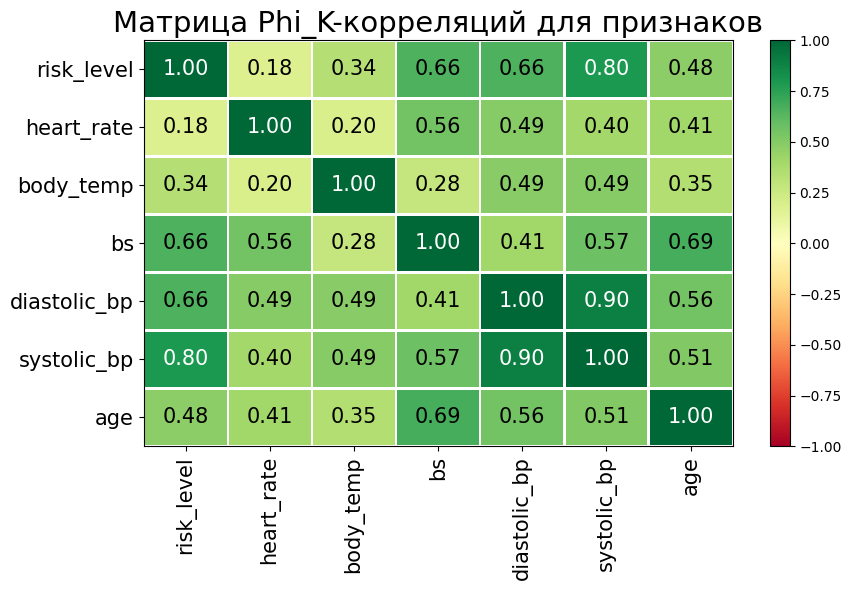

In [11]:
def Pirson_heat():

    # Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
    for i in tqdm(range(1)):

        corr_matrix = data.phik_matrix()
        plot_correlation_matrix(corr_matrix.values, 
                                x_labels=corr_matrix.columns, 
                                y_labels=corr_matrix.index, 
                                title="Матрица Phi_K-корреляций для признаков", 
                                fontsize_factor=1.5, 
                                figsize=(9, 6));
        plt.tight_layout()
        
Pirson_heat()    

**Отмечаем:**
1. Отсутствие признаков, очень сильно коррелирующих с целевым признаком.
2. Признаки 'высокое АД' и 'низкое АД' сильно коррелируют друг с другом. 
3. Признаки 'высокое АД' и 'низкое АД' наиболее сильно из всех других коррелируют с target.

## 4.2 Создание цифрового целевого признака.

Создадим признак, имеющий значения:
   * `high risk` ------> `2`,
   * `mid risk `  ------> `1`,
   * `low risk ` ------> `0`.

In [12]:
# Словарь значений риска:
dict_risks = {  'low risk':0, 'mid risk':1, 'high risk':2, }

# Создание нового признака
data['risk'] = data['risk_level'].apply(lambda key: dict_risks[key])
data

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,risk
0,25,130,80,15.000,36.667,86,high risk,2
1,35,140,90,13.000,36.667,70,high risk,2
2,29,90,70,8.000,37.778,80,high risk,2
3,30,140,85,7.000,36.667,70,high risk,2
4,35,120,60,6.100,36.667,76,low risk,0
...,...,...,...,...,...,...,...,...
1009,22,120,60,15.000,36.667,80,high risk,2
1010,55,120,90,18.000,36.667,60,high risk,2
1011,35,85,60,19.000,36.667,86,high risk,2
1012,43,120,90,18.000,36.667,70,high risk,2


**Отмечаем**, что новый признак успешно создан.

## 4.3 Исследование сбалансированности целевого признака.

In [13]:
target_distribution = data['risk'].value_counts()
display(target_distribution)

0    406
1    336
2    272
Name: risk, dtype: int64

**Отмечаем** дисбаланс данных в 'target' (количество беременных с низким уровнем риска в два раза больше количества беременных с каждым из других уровней риска (высокий, средний).

**Принимаем решение** использовать в качестве основной метрику ROC-AUC, которая не чувствительна к дисбалансу классов и оставляем все, как есть.

## 4.4 Изучение распределения каждого из трёх видов рисков по полным диапазонам значений признаков.

### 4.4.1 Распределение рисков по диапазону значений признаков.

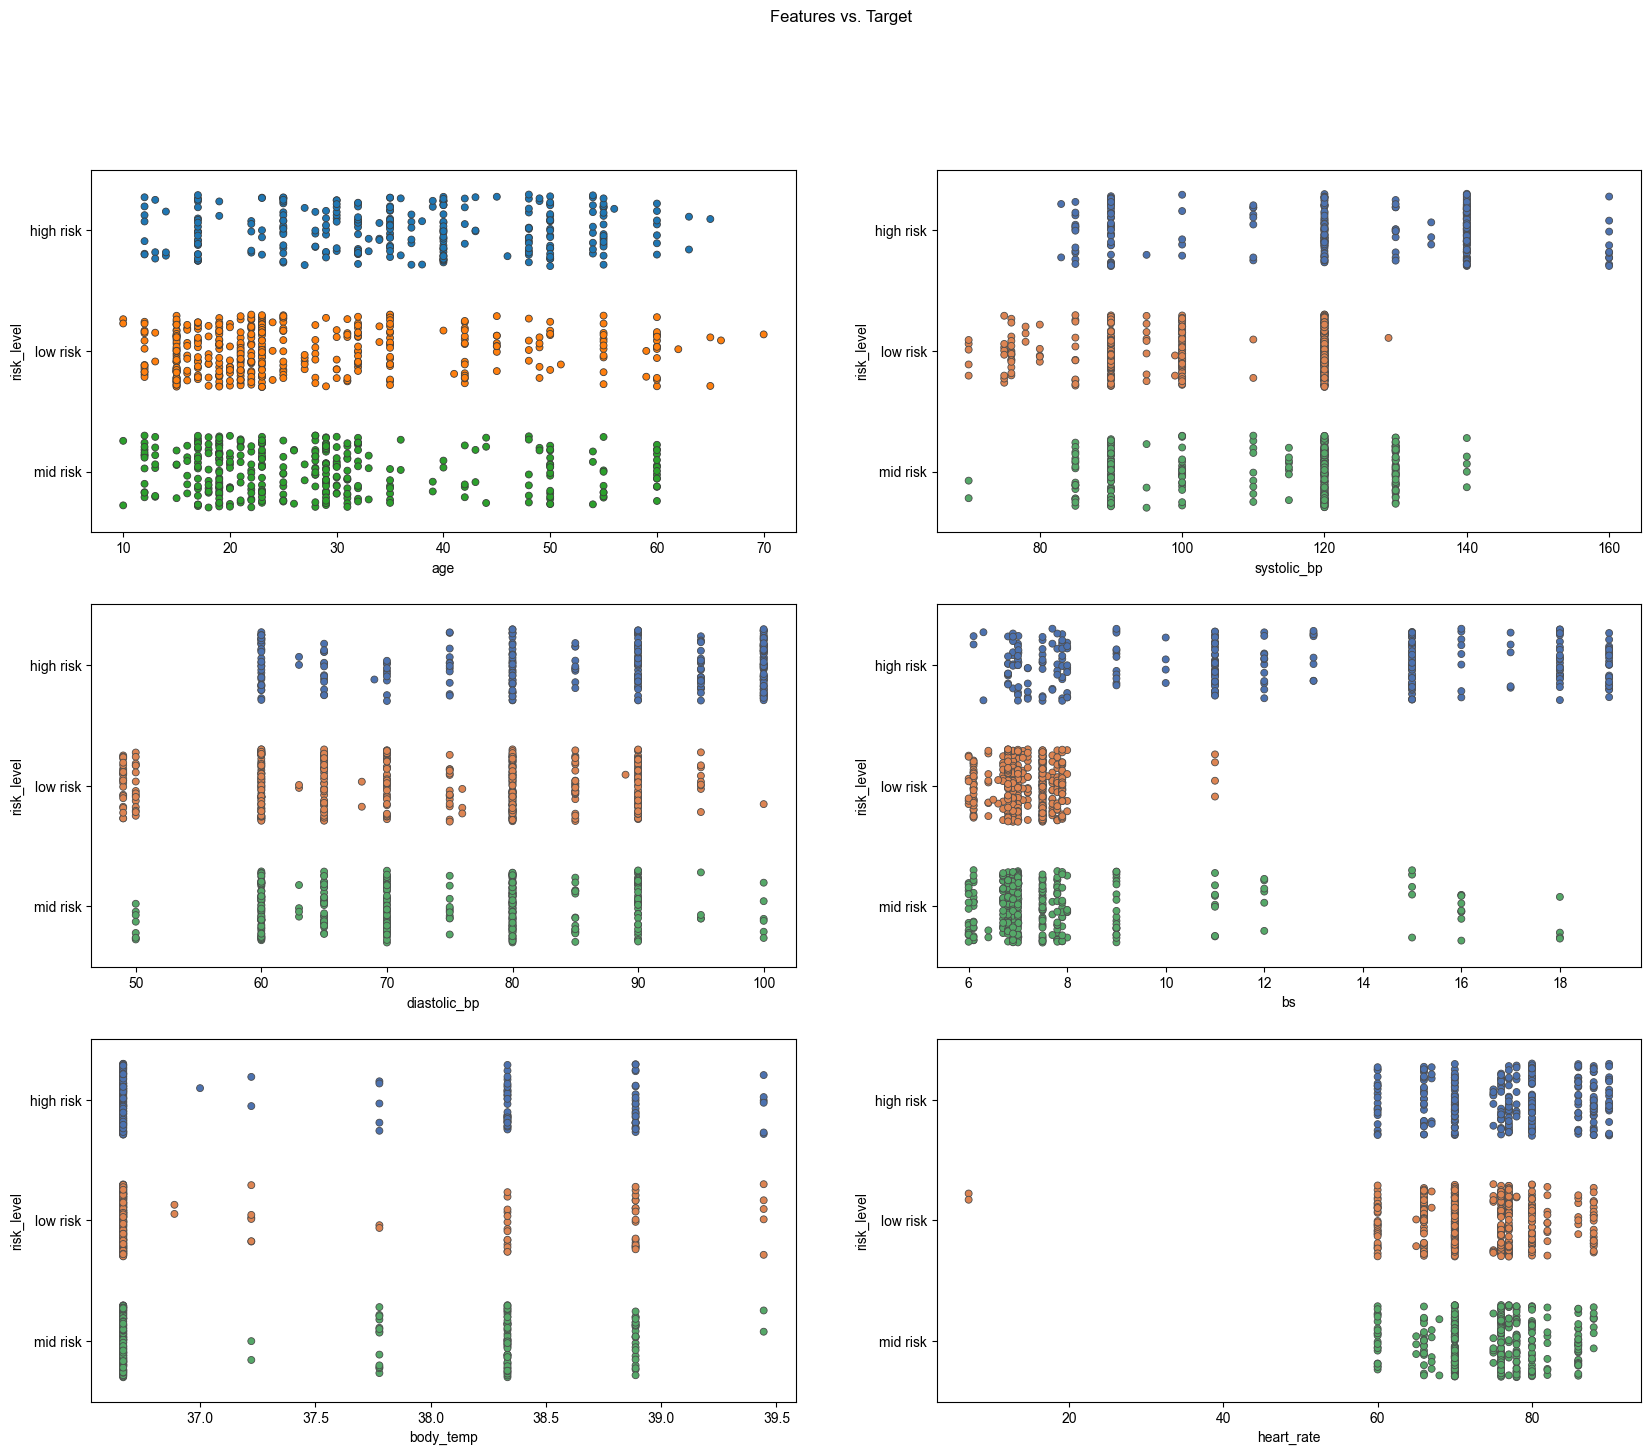

In [14]:
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Features vs. Target')
sns.set_style('whitegrid')

features = data.columns.tolist()[:-2]
for n in range(len(features)):
    ax = sns.stripplot(x=data[features[n]], y=data.risk_level,
                  linewidth=0.6, jitter= 0.3, ax=axes[int(n/2), n%2])
    sns.set(font_scale=1.2)   

**Отмечаем**:
1. Для всех видов рисков характерно распределение по всему диапазону значений признаков. Нет ярко выраженной зависимости какого-либо риска от значений признаков.
2. Отмечаем единичные аномальные значения при низком уровне риска в признаках:
    * 'bs' - *уровень глюкозы в крови*;
    * 'heart_rate' - *частота сердечных сокращений*.   
    Рассмотрим их на 'диаграмме с усами'.

### 4.4.2 Аномальные значения `bs` - *уровень глюкозы в крови*.

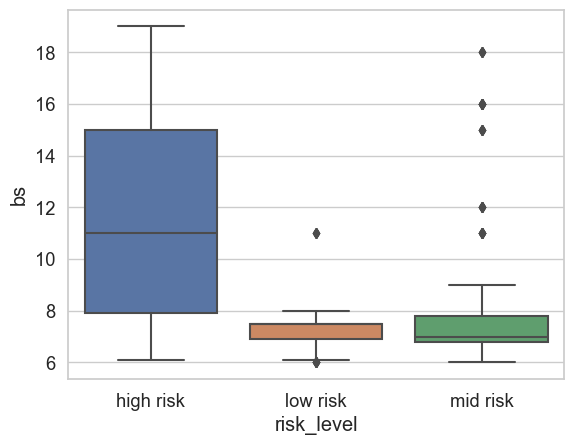

In [15]:
# Построим 'ящик с усами'.
sns.set_style("whitegrid") 
sns.boxplot(x = 'risk_level', y = 'bs', data = data);

**Отмечаем**:
* аномально высокое значение для *low_risk*,
* наличие пяти аномальных значений для *mid_risk*.

In [16]:
# Проведём сортировку по убыванию значения 'bs' и 
# выведем первые 7 максимальных значений значений для 'mid risk' и 'low risk'.
(data[['bs', 'risk_level']].sort_values(['bs'],ascending=False).
                            groupby('risk_level').
                            head(10)[10:])

,bs,risk_level
802,18.000,mid risk
797,18.000,mid risk
460,18.000,mid risk
444,18.000,mid risk
604,16.000,mid risk
787,16.000,mid risk
755,16.000,mid risk
331,16.000,mid risk
819,16.000,mid risk
833,16.000,mid risk


**Отмечаем**:
* наличие аномально высоких значений 'bs' (уровня глюкозы в крови), равных 11 ммоль/л для 'low risk';
* наличие аномально высоких значений 'bs' (уровня глюкозы в крови), более 11 ммоль/л для 'mid risk'.

**Решение** такие значения присутствуют также и для высокого значения риска, их появление непонятно. Чтобы не влиять на наши данные, оставим их как есть.

In [17]:
# Проведём сортировку по убыванию значения 'bs' и 
# выведем первые 7 максимальных значений значений для 'mid risk' и 'low risk'.
(data[['bs', 'risk_level']].sort_values(['bs'],ascending=False).
                            groupby('risk_level').
                            head(7)[7:])

,bs,risk_level
802,18.000,mid risk
797,18.000,mid risk
460,18.000,mid risk
444,18.000,mid risk
604,16.000,mid risk
787,16.000,mid risk
755,16.000,mid risk
465,11.000,low risk
895,11.000,low risk
478,11.000,low risk


### 4.4.3 Аномальные значения 'heart_rate' - *частота сердечных сокращений*.  

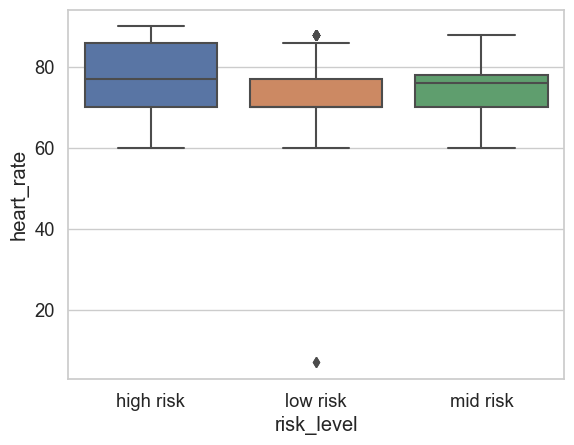

In [18]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'risk_level', y = 'heart_rate', data = data);

**Отмечаем**: единичное аномально низкое значение 'Частота сердечных сокращений' для *low_risk*.
    
Посмотрим его.

In [19]:
# Проведём сортировку по возрастанию значения 'heart_rate' и выведем первые 5 минимальных значений.
data.sort_values (by = 'heart_rate').head(5)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,risk
908,16,120,75,7.900,36.667,7,low risk,0
499,16,120,75,7.900,36.667,7,low risk,0
702,21,90,50,6.900,36.667,60,low risk,0
783,12,120,95,6.800,36.667,60,mid risk,1
784,35,100,70,6.800,36.667,60,mid risk,1


**Отмечаем**:
* аномально низкое значение 'heart_rate', равное 7, несовместимое с жизнью;
* по всей вероятности, значение было введено с ошибкой и была упущена вторая цифра. Число должно быть в диапазоне от 70 до 79.
**Решение**. Так как невозможно проверить истинное значение, и в силу малочисленности(2) ошибки, удалим запись с таким значением.

In [20]:
data = data[data.heart_rate != 7]
data.sort_values(by = 'heart_rate').head(5)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,risk
53,19,120,85,7.000,36.667,60,low risk,0
408,12,120,95,6.800,36.667,60,mid risk,1
409,35,100,70,6.800,36.667,60,mid risk,1
410,19,120,90,6.800,36.667,60,mid risk,1
792,25,120,100,6.800,36.667,60,mid risk,1


### 4.4.4 Проверка количества удалённых записей.  

In [21]:
print('Из общего количества уникальных записей в датафрейме', data_size, end='')
print(' удалена', data_size - data.shape[0], 'строк.')

Из общего количества уникальных записей в датафрейме 1014 удалена 2 строк.


**Промежуточные выводы**:
1. Проведён анализ на мультиколлинеарность признаков. Установлено, что признаки 'высокое АД' и 'низкое АД' наиболее сильно из всех других коррелируют с target.
2. Создан цифровой целевой признак 'risk'.
3. Проведено исследование сбалансированности целевого признака. Обнаружен дисбаланс данных в 'target' (количество беременных с низким уровнем риска в два раза больше количества беременных с каждым из других уровней риска (высокий, средний). Решено использовать в качестве основной метрику *ROC-AUC*, которая не чувствительна к дисбалансу классов.
4. Провелено исследование распределения каждого из трёх видов рисков по всему диапазону значений признаков. Зависимости какого-либо риска от значений признаков не установлено.
5. Удалены записи с аномальными значениями 'heart_rate', несовместимыми с жизнью.

# 5. Разделение на выборки train и test.

In [22]:
# Разделение на выборки train и test выделим в отдельную функцию.

def my_train_test(df):
    '''
    Функция разделения на выборки train и test
    '''

    # Выделим целевой признак:
    features = df.drop(['risk_level', 'risk'], axis=1)
    target = df['risk']

    # Разделим данные на обучающую и тестовую выборки:
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=TEST_SIZE_FIX, random_state=RANDOM_STATE_FIX,
        stratify=target)

    print('Проверим данные после разбиения на выборки, нет ли потерь:\n')

    if( df.shape[0] == (features_train.shape[0] + features_test.shape[0])):
        print('После разделения датафрейма в обучающей выборке потерь нет.')
    else:
        print('ВНИМАНИЕ! Есть потеря данных в обучающей выборке.\n' \
              'Сумма количества объектов в обучающей выборке НЕ равно ' \
              'количеству объектов исходного датафрейма.')
        print(df.shape[0], features_train.shape[0] + features_test.shape[0])

    if( data.shape[0] == (target_train.shape[0] + target_test.shape[0])):
        print('После разделения датасета в тестовой выборке потерь нет.')
    else:
        print('ВНИМАНИЕ! Есть потеря данных в тестовой выборке.\n' \
              'Сумма количества объектов в тестовой выборке НЕ равно ' \
              'количеству объектов исходного датасета.')
        print(df.shape[0], target_train.shape[0] + target_test.shape[0])
        
    return features_train, features_test, target_train, target_test    
        
        
features_train, features_test, target_train, target_test = my_train_test(data) 

Проверим данные после разбиения на выборки, нет ли потерь:

После разделения датафрейма в обучающей выборке потерь нет.
После разделения датасета в тестовой выборке потерь нет.


Проверим, стратификацию разбиений данных по рискам, т.е насколько соотношение между данными с рисками в выборках train и test соответствуют соотношениям в исходном датафрейме.

In [23]:
data.name = 'data'
target_train.name = 'target_train'
target_test.name = 'target_test'

df_proportion = pd.DataFrame(columns=[
    'name_of_dataframe', 'summa_rows', 
    'num_high_risk', '%_high_risk', 'high_low', 
    'num_mid_risk',  '%_mid_risk',  'mid_low',   
    'num_low_risk',  '%_low_risk', 
    ])
    

def set_df_proportion(df_prop, df, feature):

    sum = (df.loc[feature == 2].shape[0] +
           df.loc[feature == 1].shape[0] +
           df.loc[feature == 0].shape[0])

    df_prop.loc[len(df_prop.index )] = \
        [df.name, 
         sum, 
         df.loc[feature == 2].shape[0],
         f"{df.loc[feature == 2].shape[0]/sum:.0%}",
         df.loc[feature == 0].shape[0] / df.loc[feature == 2].shape[0],
         df.loc[feature == 1].shape[0],
         f"{df.loc[feature == 1].shape[0]/sum:.0%}",
         df.loc[feature == 0].shape[0] / df.loc[feature == 1].shape[0],
         df.loc[feature == 0].shape[0],
         f"{df.loc[feature == 0].shape[0]/sum:.0%}",
        ]    

set_df_proportion(df_proportion, data, data['risk'])
set_df_proportion(df_proportion, target_train, target_train)
set_df_proportion(df_proportion, target_test, target_test)
df_proportion

,name_of_dataframe,summa_rows,num_high_risk,%_high_risk,high_low,num_mid_risk,%_mid_risk,mid_low,num_low_risk,%_low_risk
0,data,1012,272,27%,1.485,336,33%,1.202,404,40%
1,target_train,759,204,27%,1.485,252,33%,1.202,303,40%
2,target_test,253,68,27%,1.485,84,33%,1.202,101,40%


**Промежуточные выводы**, 
1. Созданы обучающая и тестовая выборки.
2. Пропорции между записями с различными значениями риска после разбиения на выборки сохранены!
3. Дисбаланс классов не велик. Максимум в 1.5 раза. Дополнять или сокращать классы не разумно.   
4. Пробовал "Взвешивание классов"  class_weight='balanced':   
    *class_weights = compute_class_weight('balanced', classes=np.unique(data['risk']), y=data['risk'])*  
    Нет улучшения.
5. Увеличение выборки (Oversampling). Эффект **наилучший** из всего, что пробовал.
6. Уменьшение выборки (Undersampling). Эффект слабее, чем с Oversampling.
7. Генерация синтетических данных (SMOTE (Synthetic Minority Over-sampling Technique)). Эффект слабее, чем с Oversampling.

In [24]:
# Увеличение выборки (Oversampling)

# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным
features_train, target_train = ros.fit_resample(features_train, target_train)

# 6. Модели множественной классификации  c GridSearchCV.

**Создание вспомогательных функций.**

In [25]:
# колонки для датафрейма с результатами работы моделей
df_results = pd.DataFrame(columns=[
    'name_of_model', 'log_loss', 'ROC-AUC',
    'Accuracy', 'fitting_time,с', 'parameters'])


# Сорварь с набором отработанных моделей.
dictionary_models = {}


# Функция для перевода секунд в часы, минуты...
def exec_time(diff_time):
    '''
    Перевод секунд в часы, минуты ...
    '''
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return ("{0:02d}ч:{1:02d}м:{2:02d}с".format(h, m, s))


def model_fit_time_metrics(df, model, model_name, X, y, X_test, y_test):
    '''
    Функция обучения модели, измерения времени обучения,
    расчёта метрик, сохранения результатов в датасет и 
    создания словаря из обученных моделей.
    '''   
    start = time.time()
    
    model.fit(X, y)
    metric_roc_auc = roc_auc_score(y, model.predict_proba(X), multi_class='ovo')
    metric_accuracy = accuracy_score(y, model.predict(X)) 
    
    fit_time = time.time() - start
    
    if model_name not in list(df['name_of_model']):  
        df.loc[len(df.index )] = [model_name, -model.best_score_, 
            metric_roc_auc, metric_accuracy, 
            round(fit_time, 2), model.best_params_]
        dictionary_models[model_name] = model
        
        display(df)  

In [26]:
def best_model_param(model):
    '''
    Функция печати:
    - лучших значений гиперпараметров,
    - логистической функции ошибки,
    - лучшей модели.
    '''
    # Print the best hyperparameters
    print('Best Hyperparameters: ', model.best_params_)

    # Print the Log Loss value
    print("Best Log Loss Value: {:.3f}".format(-model.best_score_))

    # Access the best estimator/model
    print('Best Model: ', model.best_estimator_)

    
def error_matrix(model, name_model, X_test, y_test):
    '''
    Функция для построения матрицы ошибок
    '''
    predictions = model.predict(X_test)
           
    print(classification_report(y_test, predictions))
    
    sum = 0
    for key, val in dict_risks.items():
        print("{0:>9}:{1:3d}".format(key, list(predictions).count(val)))
        sum += list(predictions).count(val)
    print("{0:>9}:{1:3d}".format('total', sum))     
    print()
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)   
    ax.xaxis.set_ticklabels(list(dict_risks.keys()))
    ax.yaxis.set_ticklabels(list(dict_risks.keys()))
    plt.rcParams.update({'font.size': 24})
    plt.grid(False)
    _ = ax.set_title(f"Сonfusion matrix '{name_model}' model.",
                     fontsize=12, color='red')
    plt.show()


def graph_ROC_curv(model, name_model, X_test, y_test):
    '''
    Функция построения графиков ROC_AUC для всех значений риска.
    '''
    # Get risk probability scores
    risk_prob = model.predict_proba(X_test)
       
    print()
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(len(dict_risks.keys())):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, risk_prob[:,i], pos_label=i)

    # Plot the ROC chart
    tup = ( 'green', 'blue', 'orange' )
    for i in range(3):
        plt.plot(fpr[i], tpr[i], linestyle='--',color=tup[i], 
                 label=list(dict_risks.keys())[i])
        
    plt.title(f"Multiclass ROC-curve for '{name_model}' model.", 
              fontsize=14, color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    plt.legend()
    plt.show()

Для оценки качества моделей применим метрики `ROC-AUC` и `Accuracy`.

## 6.1. Линейные модели.

#### Масштабирование численных признаков обучающей выборки для модели линейной регрессии.

Преобразуем данные с помощью структуры для стандартизации данных — 'StandardScaler'.

In [27]:
features_train_scaler = deepcopy(features_train)
features_test_scaler = deepcopy(features_test)


# Соберем список признаков для масштабирования:
numeric = features_train_scaler.columns

# Создадим объект структуры StandardScaler:
scaler = StandardScaler()

# Настроим объект на обучающих данных:
scaler.fit(features_train_scaler[numeric]) 

# Преобразуем обучающую выборку функцией transform():
features_train_scaler[numeric] = scaler.transform(features_train_scaler[numeric])  

# Преобразуем тестовую выборку этим же scale функцией transform():
features_test_scaler[numeric] = scaler.transform(features_test_scaler[numeric]) 

# features_train_scaler.head(2)

### 6.1.1. `Логистическая регрессия` c GridSearchCV.

In [28]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    folds = KFold(n_splits=5, random_state=RANDOM_STATE_FIX, shuffle=True)

    num_features = len(features_train.columns)
    hyper_params = [{'n_features_to_select': list(range(0, num_features))}]

    lm = LogisticRegression()
    lm.fit(features_train, target_train)
    rfe = RFE(lm) 

    grid_model = GridSearchCV(estimator = rfe,
                              param_grid = hyper_params,
                              scoring= 'neg_log_loss',
                              cv = folds,
                              verbose = 1,
                              return_train_score=True)
    
    model_fit_time_metrics(df_results, grid_model, lm.__class__.__name__, 
                           features_train_scaler,target_train,
                           features_test_scaler, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}


### 6.1.2.  Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

In [29]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth':range(1, 10)}
    
    model = DecisionTreeClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
        scoring='neg_log_loss', verbose=1)
    
    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}


## 6.2. Ансамблевые методы классификации.

### 6.2.1. Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.

In [30]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth': range(11, 16),
                  'n_estimators': range(95, 101)}

    model = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5,
                              scoring='neg_log_loss', verbose=1)

    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
2,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"


### 6.2.2. Модель `GradientBoostingClassifier` c подбором гиперпараметров GridSearchCV.

In [31]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(3, 8),
                  'n_estimators': range(60, 71), 
                  'learning_rate': [0.1] }
    
    model = GradientBoostingClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
                              scoring='neg_log_loss', verbose=1)
    
    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 55 candidates, totalling 275 fits


,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
2,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"
3,GradientBoostingClassifier,0.368,0.992,0.939,98.930,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}"


## 6.3. Итеративные модели.

### 6.3.1. Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.

In [32]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' :  range(8, 13),
                  'n_estimators': range(920, 931), 
                  'learning_rate': [0.01]}
    
    model = LGBMClassifier(random_state=RANDOM_STATE_FIX, objective='binary')
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_log_loss', verbose=1)
    
    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 55 candidates, totalling 275 fits


,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
2,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"
3,GradientBoostingClassifier,0.368,0.992,0.939,98.930,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}"
4,LGBMClassifier,0.413,0.993,0.942,81.380,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 930}"


### 6.3.2. Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.

In [33]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(1, 11),
                  'iterations': range(455, 461),
                  'verbose': [0]
                 }
    
    model = CatBoostClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_log_loss')
    
    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
2,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"
3,GradientBoostingClassifier,0.368,0.992,0.939,98.930,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}"
4,LGBMClassifier,0.413,0.993,0.942,81.380,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 930}"
5,CatBoostClassifier,0.395,0.994,0.944,124.070,"{'iterations': 456, 'max_depth': 7, 'verbose': 0}"


### 6.3.3. Модель градиентного бустинга `XGBoost` с использованием GridSearch.

In [34]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(15, 25),
                  'n_estimators': range(15, 25)}
    
    model = XGBClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_log_loss')
    model_fit_time_metrics(df_results, grid_model, model.__class__.__name__, 
                           features_train,target_train,
                           features_test, target_test)

  0%|          | 0/1 [00:00<?, ?it/s]

,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}
1,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
2,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"
3,GradientBoostingClassifier,0.368,0.992,0.939,98.930,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}"
4,LGBMClassifier,0.413,0.993,0.942,81.380,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 930}"
5,CatBoostClassifier,0.395,0.994,0.944,124.070,"{'iterations': 456, 'max_depth': 7, 'verbose': 0}"
6,XGBClassifier,0.379,0.994,0.944,8.500,"{'max_depth': 15, 'n_estimators': 21}"


**Промежуточные выводы:**

* Построены две линейные модели:
    * Модель `Логистической регрессии` 'LogisticRegression' с механизмом кросс-валидации.
    * Модель `Дерево решений` 'Decision Tree' с подбором глубины дерева.
* Построены две ансамблевые модели c подбором гиперпараметров GridSearchCV:
    * Модель `Cлучайного леса` 'RandomForestClassifier'.
    * Модель `Градиентного бустинга` 'GradientBoostingClassifier'.
* Построены три итеративные модели c подбором гиперпараметров GridSearchCV:
    * Модель градиентного бустинга `LightGBM`.
    * Модель градиентного бустинга `CatBoost`.
    * Модель градиентного бустинга `XGBoost`.

## 6.4. Выбор лучшей модели (по метрике ROC-AUC).

In [35]:
# Отсортируем модели по значению MAE:
df_final = df_results.sort_values(by = ['ROC-AUC'], ascending = False)
df_final = df_final.reset_index(drop=True)
df_final

,name_of_model,log_loss,ROC-AUC,Accuracy,"fitting_time,с",parameters
0,XGBClassifier,0.379,0.994,0.944,8.500,"{'max_depth': 15, 'n_estimators': 21}"
1,CatBoostClassifier,0.395,0.994,0.944,124.070,"{'iterations': 456, 'max_depth': 7, 'verbose': 0}"
2,LGBMClassifier,0.413,0.993,0.942,81.380,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 930}"
3,GradientBoostingClassifier,0.368,0.992,0.939,98.930,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}"
4,RandomForestClassifier,0.410,0.991,0.941,21.270,"{'max_depth': 14, 'n_estimators': 96}"
5,DecisionTreeClassifier,0.707,0.818,0.658,0.210,{'max_depth': 3}
6,LogisticRegression,0.790,0.816,0.603,0.980,{'n_features_to_select': 4}


Наибольшее значение ROC-AUC, равное 0.994  имеет модель: XGBClassifier


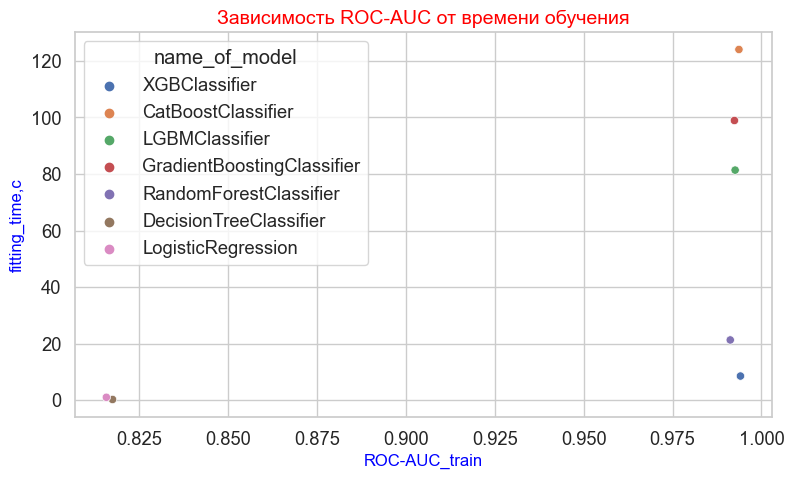

In [36]:


print('Наибольшее значение ROC-AUC, равное', 
      round(df_final['ROC-AUC'][0], 3), \
      ' имеет модель:', df_final.name_of_model[0])

# Представим все отработанные модели на графике.

plt.figure(figsize = (9,5))
sns.scatterplot(data = df_final, 
                x ='ROC-AUC', y='fitting_time,с', hue="name_of_model")
plt.title('Зависимость ROC-AUC от времени обучения',
          fontsize=14, color='red')
plt.xlabel("ROC-AUC_train", fontsize=12, color='blue')
plt.ylabel("fitting_time,с", fontsize=12, color='blue');
plt.show()

## 6.5. Значение ROC_AUC лучшей модели по тестовой выборке.

In [37]:
# Сохранимп наилучшую модель под рлнятным имененм.
the_best_model = dictionary_models[df_final.name_of_model[0]] 

metric_roc_auc_test = roc_auc_score(target_test, 
    the_best_model.predict_proba(features_test), multi_class='ovo')

print("Значение ROC_AUC лучшей модели - {} по тестовой выборке равно {:.3f}.".
      format(df_final.name_of_model[0], metric_roc_auc_test))

Значение ROC_AUC лучшей модели - XGBClassifier по тестовой выборке равно 0.965.


## 6.6. Анализ важности признаков лучшей модели.

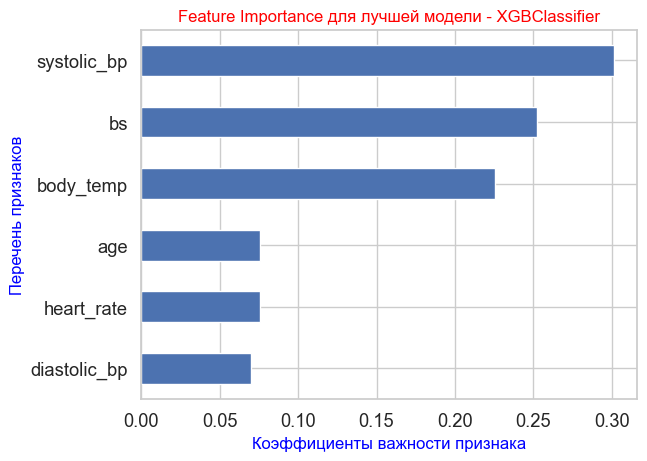

In [38]:
# Построим таблицу важности обучающих признаков:
pd.Series(index=features_train.columns, 
          data=the_best_model.best_estimator_.feature_importances_) \
    .sort_values().plot(kind='barh')
_ = plt.title(f"Feature Importance для лучшей модели - {df_final.name_of_model[0]}",
              fontsize=12, color='red')
plt.xlabel("Коэффициенты важности признака", fontsize=12, color='blue')
plt.ylabel("Перечень признаков", fontsize=12, color='blue');

**Отмечаем**:
* Наиболее важными для учёта риска беременных являются:
    * `SystolicBP` - верхнее артериальное давление, 70 ... 160 мм рт.ст.
    * `BS` - уровень глюкозы в крови, 6 ... 19 ммоль/л.
    * `BodyTemp` - температура человека, 98 ... 100 градусов по Фаренгейту (°F).

## 6.7. Матрица ошибок лучшей модели на тестовой выборке.

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       101
           1       0.78      0.83      0.80        84
           2       0.84      0.93      0.88        68

    accuracy                           0.84       253
   macro avg       0.84      0.85      0.84       253
weighted avg       0.85      0.84      0.84       253

 low risk: 88
 mid risk: 90
high risk: 75
    total:253



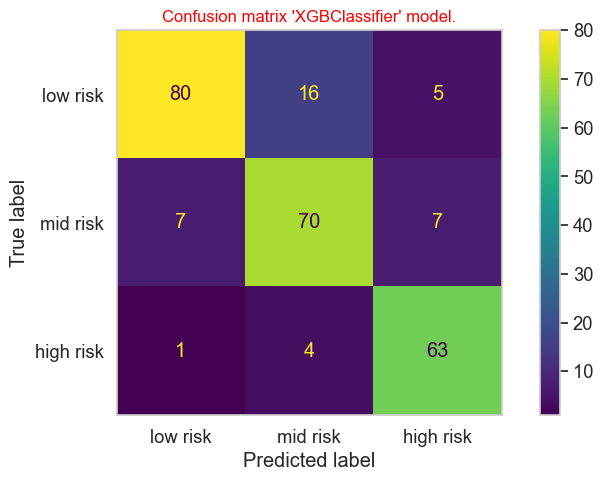

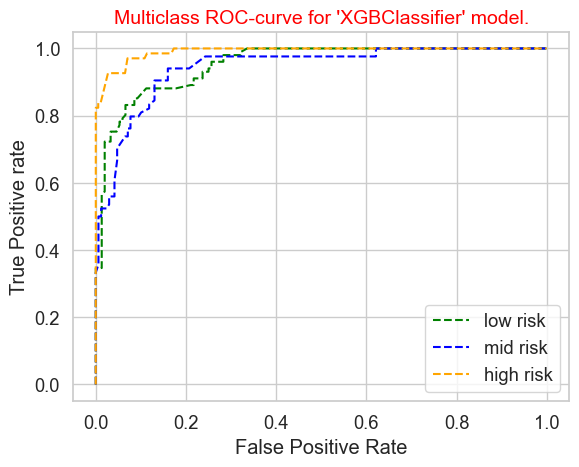

In [39]:
# Матрица ошибок на тестовой выборке.
error_matrix(the_best_model, df_final.name_of_model[0],
             features_test, target_test)

graph_ROC_curv(the_best_model, df_final.name_of_model[0],
               features_test, target_test)

**Промежуточные выводы**:
1. Созданы и обучены следующие модели:
* Две линейные модели:
    * Модель `Логистической регрессии` 'LogisticRegression' с механизмом кросс-валидации.
    * Модель `Дерево решений` 'Decision Tree' с подбором глубины дерева.
* Две ансамблевые модели:
    * Модель `Cлучайного леса` 'RandomForestClassifier'.
    * Модель `Градиентного бустинга` 'GradientBoostingClassifier'.
* Три итеративные модели:
    * Модель градиентного бустинга `LightGBM`.
    * Модель градиентного бустинга `CatBoost`.
    * Модель градиентного бустинга `XGBoost`. 
2. Лучшей стала модель `XGBClassifier` со значением ROC-AUC на обучающей выборке 0.994.
3. Значение `ROC_AUC` лучшей модели - XGBClassifier по тестовой выборке равно `0.963`.
4. Проведён анализ анализ важности признаков лучшей модели. Наиболее важными для учёта риска беременных являются:
    * `SystolicBP` - верхнее артериальное давление, 70 ... 160 мм рт.ст.
    * `BS` - уровень глюкозы в крови, 6 ... 19 ммоль/л.
    * `BodyTempе` - температура человека, 98 ... 100 градусов по Фаренгейту (°F).
5. Построена `Матрица ошибок` для лучшей модели. Отмечаем:
* Малое количество ошибок при идентификации 'high risk'. Всего 1 случай на 68 записей. И ещё 1 случай предсказания 'mid risk'.
* На 100 случаев реальных'low risk' предсказано 4 случая 'high risk'. Это не очень страшно, так как главное - не упустить случай с высоким риском. А при подозрении можно пройти дополнительное тестирование.
6. Построены `ROC-кривые (кривые ошибок)` для каждого значения риска.
* Отмечаем самое высокое значение ROC-AUC для 'high risk'. Это хорошо, что он предсказывается даже лучше других.
* Начиная со значения FP более 0.1, 'mid risk' выявляется лучше, по сравнению с 'low risk'.

In [40]:
# Запишем лучшую модель в отдельный датафрейм.
df_best_models = pd.DataFrame(columns=['best_models', 'ROC-AUC for test'])

df_best_models.loc[len(df_best_models.index )] = \
    [df_final.name_of_model[0], metric_roc_auc_test]
df_best_models

,best_models,ROC-AUC for test
0,XGBClassifier,0.965


# 7. Создание моделей с применением Pipeline.

## 7.1. Обучение моделей.

In [41]:
%%time

start_time = time.time()

C_range = loguniform(1e-3, 1).rvs(10000, random_state=RANDOM_STATE_FIX).round(3)
estimators_range = uniform(1,500).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)
max_depth_range = uniform(1,30).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)

pipeline = make_imblearn_pipeline(RandomForestClassifier())
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

param_grid = [
    {   'LogisticRegression': [LogisticRegression()],
        'clf__C': C_range,
        'clf_pipeline__standardscaler': [MinMaxScaler(), StandardScaler()],
    },
    
    {
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE_FIX)],
        'clf__max_depth': max_depth_range
    },

    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE_FIX)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [GradientBoostingClassifier(random_state=RANDOM_STATE_FIX, 
                                           learning_rate=0.1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [LGBMClassifier(random_state=RANDOM_STATE_FIX, 
                               learning_rate=0.3)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
      
    {
        'clf': [CatBoostClassifier(random_state=RANDOM_STATE_FIX, verbose=0)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [XGBClassifier(random_state=RANDOM_STATE_FIX, eta=1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    }
]

Pipe_model = RandomizedSearchCV(pipeline,  
                                param_grid, 
                                n_iter=30,
                                cv=5, 
                                scoring = 'neg_log_loss',
                                random_state=RANDOM_STATE_FIX,
                               )

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    Pipe_model.fit(features_train, target_train)
    
print('best_params :', Pipe_model.best_params_)
print('-' * 50)
print('best_score :', round(abs(Pipe_model.best_score_), 3)) 

time_pipe_working = time.time() - start_time    
print('Execiting time:', exec_time(time_pipe_working))

  0%|          | 0/1 [00:00<?, ?it/s]

best_params : {'clf__n_estimators': 276, 'clf__max_depth': 16, 'clf': <catboost.core.CatBoostClassifier object at 0x000001B0D1522310>}
--------------------------------------------------
best_score : 0.391
Execiting time: 00ч:17м:35с
CPU times: total: 45min 21s
Wall time: 17min 34s


## 7.2. Выбор лучшей модели.

In [42]:
# Посмотрим тройку лучших моделей, рассчитанных Pipeline:

pd.reset_option('all')
pd.options.display.max_colwidth = None

cv_results = pd.DataFrame(Pipe_model.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results = cv_results.reset_index(drop=True)
cv_results[['rank_test_score', 'params', 'mean_test_score', 
            'mean_fit_time']].head(3)

,rank_test_score,params,mean_test_score,mean_fit_time
0,1,"{'clf__n_estimators': 276, 'clf__max_depth': 16, 'clf': <catboost.core.CatBoostClassifier object at 0x000001B0D1522310>}",-0.390824,111.168802
1,2,"{'clf__n_estimators': 407, 'clf__max_depth': 13, 'clf': RandomForestClassifier(random_state=12345)}",-0.390898,0.593210
2,3,"{'clf__n_estimators': 349, 'clf__max_depth': 13, 'clf': <catboost.core.CatBoostClassifier object at 0x000001B0D1522310>}",-0.399075,18.296399


In [43]:
cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_estimators,param_clf__max_depth,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,111.168802,1.850747,0.005203,0.000978,276,16,<catboost.core.CatBoostClassifier object at 0x000001B0D1522310>,"{'clf__n_estimators': 276, 'clf__max_depth': 16, 'clf': <catboost.core.CatBoostClassifier object at 0x000001B0D1522310>}",-0.413843,-0.463007,-0.416906,-0.336004,-0.324360,-0.390824,0.052618,1
1,0.593210,0.004170,0.049590,0.000482,407,13,RandomForestClassifier(random_state=12345),"{'clf__n_estimators': 407, 'clf__max_depth': 13, 'clf': RandomForestClassifier(random_state=12345)}",-0.462372,-0.435855,-0.395368,-0.325304,-0.335593,-0.390898,0.053872,2
2,18.296399,0.362814,0.004800,0.000402,349,13,<catboost.core.CatBoostClassifier object at 0x000001B0D1522310>,"{'clf__n_estimators': 349, 'clf__max_depth': 13, 'clf': <catboost.core.CatBoostClassifier object at 0x000001B0D1522310>}",-0.430083,-0.480210,-0.415396,-0.329928,-0.339759,-0.399075,0.056763,3


## 7.3. Значение ROC_AUC `Pipeline` модели по тестовой выборке.

In [44]:
# Расчёт ROC_AUC для Pipeline модели.
pipe_metric_roc_auc_test = roc_auc_score(target_test, 
    Pipe_model.predict_proba(features_test), multi_class='ovo')

# Имя Pipeline модели.
text = str(cv_results.params[0]['clf'])
try:
    found = re.search('(.+?)Classifier', text).group(1) + 'Classifier'
except AttributeError:
    found = ''

print("Значение ROC_AUC лучшей модели 'Pipeline {}' по тестовой выборке равно {:.3f}.".
      format(found, pipe_metric_roc_auc_test))

Значение ROC_AUC лучшей модели 'Pipeline <catboost.core.CatBoostClassifier' по тестовой выборке равно 0.960.


## 7.4. Матрица ошибок Pipeline модели на тестовой выборке.

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       101
           1       0.73      0.80      0.76        84
           2       0.85      0.91      0.88        68

    accuracy                           0.81       253
   macro avg       0.82      0.82      0.82       253
weighted avg       0.82      0.81      0.81       253

 low risk: 88
 mid risk: 92
high risk: 73
    total:253



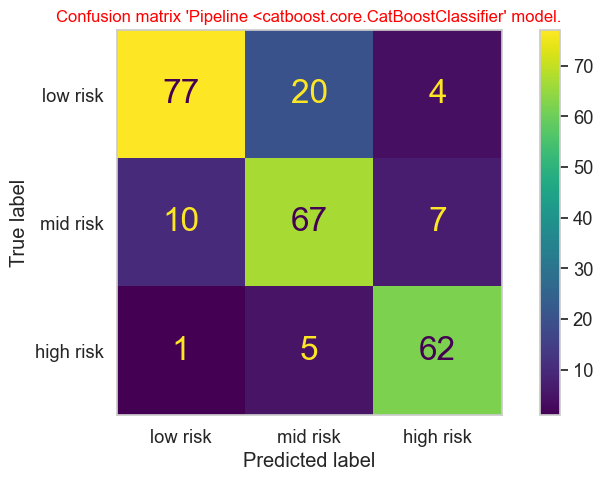

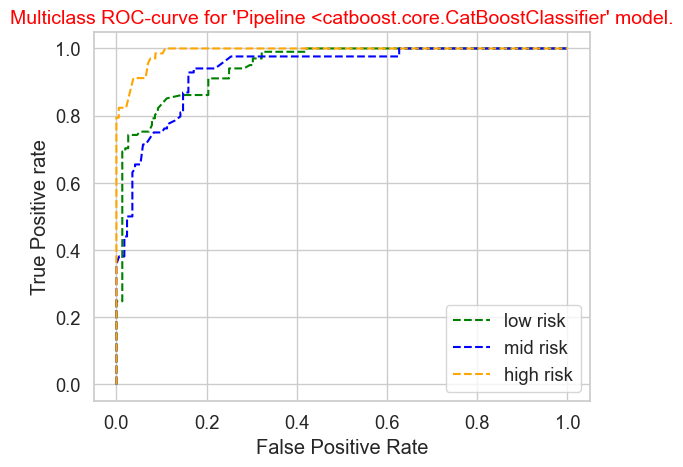

In [45]:
# Матрица ошибок на тестовой выборке.
error_matrix(Pipe_model, 'Pipeline '+found, features_test, target_test)
graph_ROC_curv(Pipe_model, 'Pipeline '+found, features_test, target_test)

**Промежуточные выводы**:

1. Построен конвейер 'Pipeline' для построения 7 моделей:
* `LogisticRegression` - линейная модель.
* `DecisionTreeClassifier` - линейная модель.
* `RandomForestClassifier` - ансамблевая модель.
* `GradientBoostingClassifier` - ансамблевая модель.
* `LGBMClassifier` - итеративная модель градиентного бустинга.
* `CatBoostClassifier` - итеративная модель градиентного бустинга.
* `XGBRFClassifier` - итеративная модель градиентного бустинга.
2. Значение `ROC_AUC` Pipeline модели `CatBoostClassifier` по тестовой выборке равно `0.960`.
3. Полное время работы конвейера 'Pipeline' около 12 минут.
4. Построена `Матрица ошибок` для 'Pipeline' модели. Отмечаем:
* Чуть большее, по сравнению с классическими ML методами количество ошибок при идентификации 'high risk'. Вместо 1, сразу 4 предсказания 'mid risk'.
* В остальном, всё как и в п.6. настоящего проекта.
5. Построены `ROC-кривые (кривые ошибок)` для каждого значения риска. Поведение ROC-кривых аналогично рассчитанным по классическим методам.

In [46]:
# Сохраним Pipeline model
model_name = 'Pipeline'
if model_name not in list(df_best_models['best_models']):  
    df_best_models.loc[len(df_best_models.index )] = \
        [model_name, pipe_metric_roc_auc_test]
    
df_best_models

,best_models,ROC-AUC for test
0,XGBClassifier,0.965017
1,Pipeline,0.959824


# 8. Голосующий ансамбль моделей  RF | GDB | LGBM | CatBoost | XGB.

## 8.1. Модель `RandomForestClassifier`.

In [47]:
# Define parameter distribution dictionary for DecisionTree Classifier
param_dist_rfc = {
    'max_depth' : randint(1, 20),
    'n_estimators': randint(100, 1000),
}

# Initialize DecisionTreeClassifier
rfc_classifier = RandomForestClassifier(random_state=RANDOM_STATE_FIX)

# Create an instance of RandomizedSearchCV
rfc_mod = RandomizedSearchCV(estimator=rfc_classifier,
                               param_distributions=param_dist_rfc,
                               scoring='neg_log_loss',  
                               cv=StratifiedKFold(n_splits= 5), 
                               n_iter=50,
                               n_jobs=-1
                              )
for i in tqdm(range(1)):
    # Fit the RF Random Model to find the best hyperparameters
    rfc_model = rfc_mod.fit(features_train, target_train)

# Расчёт и печать ROC_AUC для модели.
roc_auc_train = roc_auc_score(target_train, 
    rfc_model.predict_proba(features_train), multi_class='ovo')
print("Значение ROC_AUC модели '{}' равно {:.3f}.\n".
      format(rfc_classifier.__class__.__name__, roc_auc_train))

# Печать результатов    
best_model_param(rfc_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Значение ROC_AUC модели 'RandomForestClassifier' равно 0.989.

Best Hyperparameters:  {'max_depth': 12, 'n_estimators': 747}
Best Log Loss Value: 0.399
Best Model:  RandomForestClassifier(max_depth=12, n_estimators=747, random_state=12345)


## 8.2. Модель `GradientBoostingClassifier`.

In [48]:
# Define parameter distribution dictionary for XGBoost Classifier
param_dist_gb = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 20),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0, 1),
    'min_samples_split': randint(1, 10),
    'min_samples_leaf': randint(1, 10),
    'min_weight_fraction_leaf': uniform(0, 1),
    'max_features': uniform(0, 1),
}

# Initialize XGBoost Classifier
gb_classifier = GradientBoostingClassifier(random_state=RANDOM_STATE_FIX)

# Create an instance of RandomizedSearchCV
gb_mod = RandomizedSearchCV(estimator=gb_classifier,
                            param_distributions=param_dist_gb,
                            scoring='neg_log_loss',  
                            cv=StratifiedKFold(n_splits= 5), 
                            n_iter=50,
                            n_jobs=-1
                           )

for i in tqdm(range(1)):
    # Fit the GB Random Model to find the best hyperparameters
    gb_model = gb_mod.fit(features_train, target_train)

# Расчёт и печать ROC_AUC для модели.
roc_auc_train = roc_auc_score(target_train, 
    gb_model.predict_proba(features_train), multi_class='ovo')
print("Значение ROC_AUC модели '{}' равно {:.3f}.\n".
      format(gb_classifier.__class__.__name__, roc_auc_train))

best_model_param(gb_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Значение ROC_AUC модели 'GradientBoostingClassifier' равно 0.962.

Best Hyperparameters:  {'learning_rate': 0.10783655046915674, 'max_depth': 2, 'max_features': 0.03448968889625914, 'min_samples_leaf': 9, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.022343745836223894, 'n_estimators': 417, 'subsample': 0.7023289350975898}
Best Log Loss Value: 0.480
Best Model:  GradientBoostingClassifier(learning_rate=0.10783655046915674, max_depth=2,
                           max_features=0.03448968889625914, min_samples_leaf=9,
                           min_samples_split=7,
                           min_weight_fraction_leaf=0.022343745836223894,
                           n_estimators=417, random_state=12345,
                           subsample=0.7023289350975898)


## 8.3. Модель `LGBMClassifier`.

In [49]:
# Define parameter distribution dictionary for XGBoost Classifier
param_dist_lgbm = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'learning_rate': uniform(0.01, 0.3), 
    'n_estimators': randint(100, 500),
    'max_bin': randint(100, 300),
    'max_depth': randint(1, 20),
    'min_data_in_bin': randint(1, 10), 
    'num_iterations': randint(100, 500),
    'num_leaves': randint(100, 300),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# Initialize XGBoost Classifier
lgbm_classifier = LGBMClassifier(random_state=RANDOM_STATE_FIX)

# Create an instance of RandomizedSearchCV
lgbm_mod = RandomizedSearchCV(estimator=lgbm_classifier,
                            param_distributions=param_dist_lgbm,
                            scoring='neg_log_loss',
                            cv=StratifiedKFold(n_splits= 5),
                            n_iter=50,
                            n_jobs=-1
                           )

for i in tqdm(range(1)):
    # Fit the LGBM Random Model to find the best hyperparameters
    lgbm_model = lgbm_mod.fit(features_train, target_train)

# Расчёт и печать ROC_AUC для модели.
roc_auc_train = roc_auc_score(target_train, 
    lgbm_model.predict_proba(features_train), multi_class='ovo')
print("Значение ROC_AUC модели '{}' равно {:.3f}.\n".
      format(lgbm_classifier.__class__.__name__, roc_auc_train))

best_model_param(lgbm_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Значение ROC_AUC модели 'LGBMClassifier' равно 0.993.

Best Hyperparameters:  {'boosting_type': 'dart', 'learning_rate': 0.3048999507658046, 'max_bin': 249, 'max_depth': 19, 'min_data_in_bin': 5, 'n_estimators': 162, 'num_iterations': 106, 'num_leaves': 161, 'reg_alpha': 0.06765604421465399, 'reg_lambda': 0.6166744885583375}
Best Log Loss Value: 0.413
Best Model:  LGBMClassifier(boosting_type='dart', learning_rate=0.3048999507658046,
               max_bin=249, max_depth=19, min_data_in_bin=5, n_estimators=162,
               num_iterations=106, num_leaves=161, random_state=12345,
               reg_alpha=0.06765604421465399, reg_lambda=0.6166744885583375)


## 8.4. Модель `CatBoostClassifier`.

In [50]:
# Define parameter distribution dictionary for XGBoost Classifier
param_dist_cb = {
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(1, 20),
    'border_count': randint(100, 200),
    'colsample_bylevel': uniform(0, 1),
    'iterations': randint(100, 500),
    'l2_leaf_reg': randint(1, 20),
    'one_hot_max_size': randint(1, 20),
    'random_strength': uniform(0, 1),
    'custom_metric': ['Logloss', 'Accuracy', 'AUC'],
}


# Initialize XGBoost Classifier
cb_classifier = CatBoostClassifier(verbose = 0, random_state=RANDOM_STATE_FIX)

# Create an instance of RandomizedSearchCV
cb_mod = RandomizedSearchCV(estimator=cb_classifier,
                            param_distributions=param_dist_cb,
                            scoring='neg_log_loss',  
                            cv=StratifiedKFold(n_splits= 5), 
                            n_iter=50,
                            n_jobs=-1
                           )

for i in tqdm(range(1)):
    # Fit the CatBoost Random Model to find the best hyperparameters
    cb_model = cb_mod.fit(features_train, target_train)

# Расчёт и печать ROC_AUC для модели.
roc_auc_train = roc_auc_score(target_train, 
    cb_model.predict_proba(features_train), multi_class='ovo')
print("Значение ROC_AUC модели '{}' равно {:.3f}.\n".
      format(cb_classifier.__class__.__name__, roc_auc_train))

best_model_param(cb_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Значение ROC_AUC модели 'CatBoostClassifier' равно 0.994.

Best Hyperparameters:  {'border_count': 171, 'colsample_bylevel': 0.706558153421085, 'custom_metric': 'Accuracy', 'depth': 9, 'iterations': 160, 'l2_leaf_reg': 3, 'learning_rate': 0.2960749967930586, 'one_hot_max_size': 15, 'random_strength': 0.7193830853249346}
Best Log Loss Value: 0.397
Best Model:  <catboost.core.CatBoostClassifier object at 0x000001B0F668C730>


## 8.5. Модель `XGBoostClassifier`.

In [51]:
# Define parameter distribution dictionary for XGBoost Classifier
param_dist_xgb = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 20),
    'n_estimators': randint(100, 500),
    'min_child_weight': randint(1, 20),
    'subsample': uniform(0, 1),
    'colsample_bylevel': uniform(0, 1),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'max_delta_step': randint(0, 10),
    'objective': 'multi:softprob', 
}


# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(num_class=3,
                               random_state=RANDOM_STATE_FIX)

# Create an instance of RandomizedSearchCV
xgb_mod = RandomizedSearchCV(estimator=xgb_classifier,
                             param_distributions=param_dist_xgb,
                             scoring='neg_log_loss',  
                             cv=StratifiedKFold(n_splits= 5), 
                             n_iter=50,
                             n_jobs=-1
                            )

for i in tqdm(range(1)):
    # Fit the XGB Random Model to find the best hyperparameters
    xgb_model = xgb_mod.fit(features_train, target_train)

# Расчёт и печать ROC_AUC для модели.
roc_auc_train = roc_auc_score(target_train, 
    xgb_model.predict_proba(features_train), multi_class='ovo')
print("Значение ROC_AUC модели '{}' равно {:.3f}.\n".
      format(xgb_classifier.__class__.__name__, roc_auc_train))
    
best_model_param(xgb_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Значение ROC_AUC модели 'XGBClassifier' равно 0.992.

Best Hyperparameters:  {'colsample_bylevel': 0.4868029840261827, 'gamma': 0.011942384754755175, 'learning_rate': 0.18875065421049464, 'max_delta_step': 8, 'max_depth': 17, 'min_child_weight': 4, 'n_estimators': 245, 'objective': 'm', 'reg_alpha': 0.7581253340187767, 'reg_lambda': 0.04257849906873723, 'subsample': 0.9246643711747697}
Best Log Loss Value: 0.417
Best Model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.4868029840261827, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.011942384754755175, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.18875065421049464, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=8,
          

## 8.6. Голосование ансамбля моделей  RF | GDB | LGBM | CatBoost | XGB.

In [52]:
# Initialize base classifiers

base_classifiers_voting = [
    ('RFC', rfc_model.best_estimator_), 
    ('GDBoost', gb_model.best_estimator_), 
    ('LightGBM', lgbm_model.best_estimator_),
    ('CatBoost', cb_model.best_estimator_),  
    ('XGB', xgb_model.best_estimator_), 
]


voting_model = VotingClassifier(estimators=base_classifiers_voting, voting='soft')

In [53]:
# Initialize RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,
                               random_state=RANDOM_STATE_FIX)

# List to store Log Loss evaluation metric across folds
log_loss_list_rskf = []

# Variables to save the best model with the minimal Log Loss
best_log_loss_rskf = float('inf')  
best_model_rskf = None

for i in tqdm(range(1)):
    for train_index, test_index in rskf.split(features_train, target_train):

        X_train, X_test = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_test = target_train.iloc[train_index], target_train.iloc[test_index]

        # Train the model
        voting_model.fit(X_train, y_train)

        # Generate predictions 
        y_pred = voting_model.predict(X_test)

        # Predict Probabilities for each class
        y_probs = voting_model.predict_proba(X_test)

        # Evaluate the model
        loss_score = log_loss(y_test, y_probs)

        # Append Log Loss metric to Log Loss list
        log_loss_list_rskf.append(loss_score)

        # Save the model with the minimal Log Loss
        if loss_score < best_log_loss_rskf:
            best_log_loss_rskf = loss_score
            best_model_rskf = deepcopy(voting_model)

  0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
# Get class probability scores
risk_prob = best_model_rskf.predict_proba(features_test)

# Расчёт ROC_AUC для VotingClassifier модели.
voting_metric_roc_auc_test = \
    roc_auc_score(target_test, risk_prob, multi_class='ovo')
print("Average ROC_AUC на тестовой выборке: {:.3f}.".
      format(voting_metric_roc_auc_test))

# print("Best Voting Classifier Model Log Loss: {:.3f}.".format(best_log_loss_rskf))
print('Best Voting Classifier Model Model:', best_model_rskf)

Average ROC_AUC на тестовой выборке: 0.953.
Best Voting Classifier Model Model: VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=747,
                                                     random_state=12345)),
                             ('GDBoost',
                              GradientBoostingClassifier(learning_rate=0.10783655046915674,
                                                         max_depth=2,
                                                         max_features=0.03448968889625914,
                                                         min_samples_leaf=9,
                                                         min_samples_split=7,
                                                         min_weight_fraction_leaf=0.022343745836223894,
                                                         n_estimators=417,
                                          

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       101
           1       0.76      0.81      0.78        84
           2       0.84      0.93      0.88        68

    accuracy                           0.83       253
   macro avg       0.83      0.84      0.83       253
weighted avg       0.83      0.83      0.83       253

 low risk: 88
 mid risk: 90
high risk: 75
    total:253



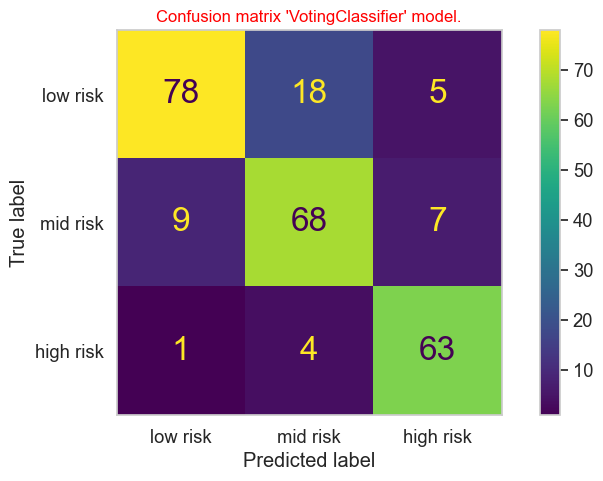

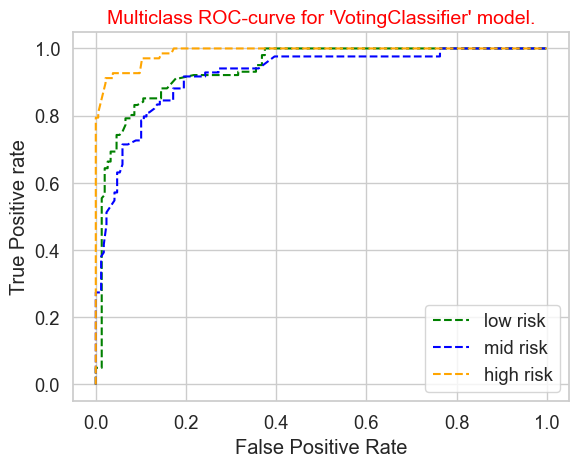

In [55]:
# Матрица ошибок на тестовой выборке.
error_matrix(best_model_rskf, best_model_rskf.__class__.__name__, features_test, target_test)
graph_ROC_curv(best_model_rskf, best_model_rskf.__class__.__name__, features_test, target_test)

**Промежуточные выводы**:

1. Построен ансамбль из моделей:
    * `RandomForestClassifier`.
    * `GradientBoostingClassifier`.
    * `LGBMClassifier`.
    * `CatBoostClassifier`.
    * `XGBRFClassifier`.
2. Для каждой модели подобраны гиперпараметры.
3. По лучшим моделям `VotingClassifier` провёл выбор самой лучшей модели.
4. Среднее по всем значениям рисков значение `ROC_AUC` для тестовой выборки равно `0.962`.
5. Построена `Матрица ошибок`. 
6. Построены `ROC-кривые (кривые ошибок)` для каждого значения риска.

In [64]:
# Сохраним Voting model
model_name = 'VotingClassifier'
if model_name not in list(df_best_models['best_models']):  
    df_best_models.loc[len(df_best_models.index )] = \
        [model_name, voting_metric_roc_auc_test]
    
display(df_best_models)

,best_models,ROC-AUC for test
0,XGBClassifier,0.965017
1,Pipeline,0.959824
2,VotingClassifier,0.953269


In [66]:
print('Наилучшей признана модель:')
THE_BEST_MODEL = the_best_model
# Pipe_model
# best_model_rskf
THE_BEST_MODEL

Наилучшей признана модель:


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=12345, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(15, 25),
                         'n_estimators': range(15, 25)},
             scoring='neg_log_loss')

# 9. Сериализация и применение лучшей модели.

## 9.1. Сохранение лучшей модели в файл.

In [57]:
with open("classifier_model", "wb") as f:
    pickle.dump(THE_BEST_MODEL, f)

## 9.2. Чтение лучшей модели из сохраненного ранее файла.

In [58]:
with open("classifier_model", "rb") as f:
    my_model = pickle.load(f)    

In [59]:
# Проверка того, что модель прочитана:
my_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=12345, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(15, 25),
                         'n_estimators': range(15, 25)},
             scoring='neg_log_loss')

## 9.3. Пример применения прогностической модели рисков беременных.

In [60]:
# Словарь значений риска:
find_risks = {0:'low risk', 1:'mid risk', 2:'high risk'}

# Запишем лучшую модель в отдельный датафрейм.
df = pd.DataFrame(columns=['age', 'systolic_bp', 'diastolic_bp', 
                           'bs', 'body_temp', 'heart_rate'])
    
print([data.iloc[2].values])
print([data.iloc[21].values])
print([data.iloc[912].values])

[array([29, 90, 70, 8.0, 37.77777777777778, 80, 'high risk', 2],
      dtype=object)]
[array([50, 140, 80, 6.7, 36.66666666666667, 70, 'mid risk', 1],
      dtype=object)]
[array([17, 120, 80, 7.5, 38.88888888888889, 76, 'low risk', 0],
      dtype=object)]


In [61]:
df.loc[len(df.index )] = [29, 90, 70, 8.0, 37.8, 80]
df.loc[len(df.index )] = [50, 140, 80, 6.7, 36.7, 70]
df.loc[len(df.index )] = [17, 90, 63, 7.5, 38.9, 70]

df['RISK'] = my_model.predict(df)
df['РИСК'] = df['RISK'].apply(lambda x: find_risks[x])
display(df)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,RISK,РИСК
0,29.0,90.0,70.0,8.0,37.8,80.0,2,high risk
1,50.0,140.0,80.0,6.7,36.7,70.0,1,mid risk
2,17.0,90.0,63.0,7.5,38.9,70.0,0,low risk


# 10. Итоговые выводы.

**По результатам исследования можно отметить следующие факты и сделать приводимые ниже выводы:**
    
1. Для проведения исследования предоставлен файл с данными `Maternal_Health_Risk_Data_Set.csv`.
2. В полученном файле находятся 1014 записей с 6 обучающими признаками и целевым `RiskLevel`. 
    * Пропусков данных нет. 
    * Значения температуры человека в градусах Фаренгейта (°F) переведены в градусы Цельсия (°C).
3. Проведён EDA анализ.  
    * Выполнена проверка мультиколлинеарности признаков и корреляции с таргетом.   
        * Установлено отсутствие признаков, очень сильно коррелирующих с целевым признаком.  
    * Создан цифровой целевой признак `risk`, имеющий значения:
        * high risk ------> 2,
        * mid risk  ------> 1,
        * low risk  ------> 0.
    * Отмечен дисбаланс данных в 'target' (количество беременных с низким уровнем риска в два раза больше количества беременных с каждым из других уровней риска (высокий, средний). Решено  использовать в качестве основной метрику ROC-AUC, которая не чувствительна к дисбалансу классов.
    * Для всех видов рисков характерно распределение по полному диапазону значений признаков. Нет ярко выраженной зависимости какого-либо риска от конкретных значений признаков.
    * Установлено наличие аномально высоких значений `bs` (уровня глюкозы в крови), равных 11 ммоль/л для 'low risk' и 'mid risk'. Такие значения присутствуют также и для высокого значения риска, их появление непонятно и по-видимому, некатастрофично. Решено не менять данные, оставить, как есть.
    * Обнаружены аномально низкие значения `heart_rate`, равные 7, несовместимые с жизнью. По всей вероятности, значения были введены с ошибкой и была упущена вторая цифра. Число должно быть в диапазоне от 70 до 79. Так как невозможно проверить истинное значение, и в силу малочисленности (всего 2 случая) ошибки, записи с такими ошибками удалены.
4. Проведено разделение на выборки train и test. Проверены различные варианты устранения дисбаланса. Оставлен показавший наибольшую эффективность `Увеличение выборки (Oversampling)`.
5. Построены модели множественной классификации.
    * Созданы и обучены модели c GridSearchCV:
        * 'Логистической регрессии' `LogisticRegression` с механизмом кросс-валидации.
        * 'Дерево решений' `DecisionTreeClassifier` с подбором глубины дерева.
        * 'Cлучайного леса' `RandomForestClassifier`.
        * `GradientBoostingClassifier`.
        * `LightGBMClassifier`.
        * `CatBoostClassifier`.
        * `XGBoostClassifier`.
    * Проведено масштабирование численных признаков обучающей выборки для модели линейной регрессии.
    * Лучшей является модель `XGBClassifier` с наибольшим значением метрики ROC-AUC 0.994.
    * Значение ROC_AUC лучшей модели XGBClassifier по тестовой выборке равно `0.963`.
    * Наиболее важными для учёта риска беременных являются:
        * `SystolicBP` - верхнее артериальное давление, 70 ... 160 мм рт.ст.
        * `BS` - уровень глюкозы в крови, 6 ... 19 ммоль/л.
        * `BodyTempе` - температура человека, 36.6 ... 40 градусов Цельсия (°С).
    * Построена `Матрица ошибок` для лучшей модели. Отмечаем:
        * Малое количество ошибок при идентификации 'high risk'. Всего 1 случай на 68 записей. И ещё 1 случай предсказания 'mid risk'.
        * На 100 случаев реальных 'low risk' предсказано 3 случая 'high risk'. Это не очень страшно, так как главное - не упустить случай с высоким риском. А при подозрении можно пройти дополнительное тестирование.
    * Построены `ROC-кривые (кривые ошибок) для каждого значения риска.
        * Отмечаем самое высокое значение ROC-AUC для 'high risk'. Метрика предсказывается для 'high risk' даже лучше, чем для других рисков.
6. Построен конвейер 'Pipeline'.
    * Созданы и обучены модели множественной классификации:
        * `LogisticRegression`.
        * `DecisionTreeClassifier`.
        * `RandomForestClassifier`.
        * `GradientBoostingClassifier`.
        * `LGBMClassifier`.
        * `CatBoostClassifier`.
        * `XGBRFClassifier`.
    * Значение `ROC_AUC` Pipeline модели `CatBoostClassifier` по тестовой выборке равно `0.960`.
    * Построена `Матрица ошибок` для 'Pipeline' модели. Отмечаем:
        * Чуть большее, по сравнению с классическими ML методами количество ошибок при идентификации 'high risk'. Вместо 1, сразу 4 предсказания 'mid risk'.
    * Построены `ROC-кривые` для каждого значения риска. Поведение ROC-кривых аналогично рассчитанным по классическим методам.
7. Построен ансамбль моделей множественной классификации и проведено голосование для выбора лучшей.
    * Созданы и обучены модели:
        * `RandomForestClassifier`.
        * `GradientBoostingClassifier`.
        * `LGBMClassifier`.
        * `CatBoostClassifier`.
        * `XGBRFClassifier`.
    * Для каждой модели предварительно подобраны оптимальные гиперпараметры.
    * По моделям с выбранными гиперпараметрами методом `VotingClassifier` проведен выбор лучшей модели.
    * Среднее по всем значениям рисков значение `ROC_AUC` для тестовой выборки равно `0.962`.
    * Построена `Матрица ошибок`. 
    * Построены `ROC-кривые (кривые ошибок)` для каждого значения риска.
8. Среди всех моделей, созданных тремя различными методами, наилучшей признана `XGBClassifier`.
9. Матрица ошибок лучшей модели на тестовой выборке.

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       101
           1       0.78      0.83      0.80        84
           2       0.84      0.93      0.88        68

    accuracy                           0.84       253
   macro avg       0.84      0.85      0.84       253
weighted avg       0.85      0.84      0.84       253

 low risk: 88
 mid risk: 90
high risk: 75
    total:253



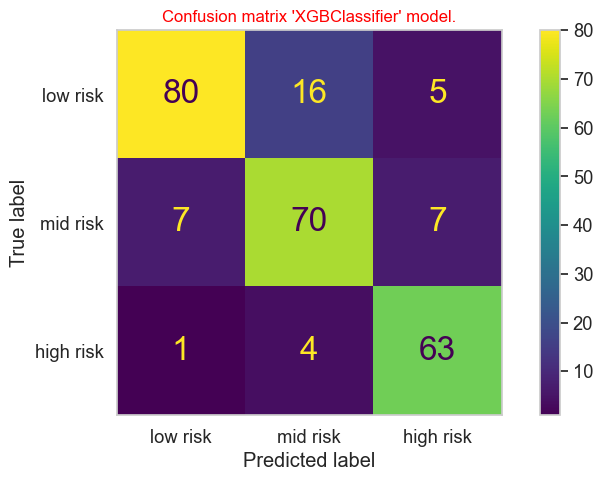

In [62]:
error_matrix(the_best_model, df_final.name_of_model[0],
             features_test, target_test)

10. Проведена сериализация лучшей прогностической модели.
11. Приведён пример чтения модели из файла и расчёта прогноза по 6 параметрам:
    * `Age` - возраст в диапазоне от 10 до 70 лет.
    * `SystolicBP` - верхнее артериальное давление, 70 ... 160 мм рт.ст.
    * `DiastolicBP` - нижнее артериальное давление, 49 ... 100 мм рт.ст.
    * `BS` - уровень глюкозы в крови, 6 ... 19 ммоль/л.
    * `BodyTempе` - температура человека, 36.6 ... 40 градусов Цельсия (°С).
    * `HeartRate` - частота сердечных сокращений, 7 ... 90 ударов в минуту.

In [63]:
display(df)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,RISK,РИСК
0,29.0,90.0,70.0,8.0,37.8,80.0,2,high risk
1,50.0,140.0,80.0,6.7,36.7,70.0,1,mid risk
2,17.0,90.0,63.0,7.5,38.9,70.0,0,low risk
